In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('datasets_combine.csv')
df =
data = df
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=False,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# LSTM Classifier Model
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        lstm_out, (hidden, _) = self.lstm(embedded)
        out = self.fc(hidden[-1])
        return out

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / len(val_loader.dataset)
    return avg_loss, accuracy

In [ ]:
# Model hyperparameters
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 2  # Adjust based on the number of target classes
num_epoch = 8

# Initialize T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')
VOCAB_SIZE = tokenizer.vocab_size

# Prepare the dataset and dataloader
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sentence'], df['label'], test_size=0.2)
train_dataset = TextDataset(train_texts.tolist(), train_labels.tolist(), tokenizer, max_length=128)
val_dataset = TextDataset(val_texts.tolist(), val_labels.tolist(), tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, OUTPUT_DIM).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epoch):  # Number of epochs
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        predictions = model(input_ids)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    print(f'Epoch: {epoch + 1}, Loss: {total_loss / len(train_loader)}')
    print(f'Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')
# Save the model
torch.save(model.state_dict(), 'lstm_model.pth')

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Epoch: 1, Loss: 0.538922638964804
Val Loss: 0.2537599606345398, Val Accuracy: 0.9245641838351822
Epoch: 2, Loss: 0.23157364433702035
Val Loss: 0.301284378977737, Val Accuracy: 0.8979397781299524
Epoch: 3, Loss: 0.11313058936473312
Val Loss: 0.07129436410549614, Val Accuracy: 0.9793977812995246
Epoch: 4, Loss: 0.0513285426243173
Val Loss: 0.05523295305913897, Val Accuracy: 0.9825673534072901
Epoch: 5, Loss: 0.03137681016527541
Val Loss: 0.07559585280603531, Val Accuracy: 0.9771790808240888
Epoch: 6, Loss: 0.024728877895623683
Val Loss: 0.05948938748204253, Val Accuracy: 0.9822503961965134
Epoch: 7, Loss: 0.015040533181760294
Val Loss: 0.06125184736741387, Val Accuracy: 0.9841521394611727
Epoch: 8, Loss: 0.008174816292085791
Val Loss: 0.07583502797713278, Val Accuracy: 0.9819334389857369


In [ ]:
def predict(text, model=model, tokenizer=tokenizer, device=device):
    model.eval()
    with torch.no_grad():
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=False,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].flatten().to(device)
        outputs = model(input_ids)

        # normalize the scores to all positive and sum to 1
        outputs = torch.nn.functional.softmax(outputs, dim=0)

        return outputs

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
from sklearn.metrics import confusion_matrix
import torch

# Load the pre-trained T5 model and tokenizer
model_name = 't5-base'
model_TST = T5ForConditionalGeneration.from_pretrained(model_name)

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
def style_transfer_t5(sentence, model, tokenizer):
    # Format the input text for the model
    pre_classification = predict(sentence, model, tokenizer, device).tolist()[0]
    if pre_classification < 0.5:
        input_text = f"transfer to news style: {sentence}"
    else:
        input_text = f"transfer to shakespeare style: {sentence}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    # Generate output using the model
    outputs = model_TST.generate(input_ids)

    # Decode the output to get the transformed text
    transformed_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return transformed_text

def wrapper_function(sentence):
    return style_transfer_t5(sentence, model, tokenizer)
df['generated_sentence'] = df['sentence'].apply(wrapper_function)



sentence = "Claims she suffered catalogue of abuse at hands of Italian former partner"
transformed_sentence = style_transfer_t5(sentence, model, tokenizer)
print(transformed_sentence)  # This should print the transformed sentence
prediction_label = predict(transformed_sentence, model, tokenizer, device)
prediction_label.tolist()

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Accusations she suffered catalogue of abuse at hands of Italian former partner at hands of shake


[0.9994456171989441, 0.0005544085870496929]

In [ ]:
# Example usage
def style_transfer_t5(sentence, model, tokenizer):
    # Format the input text for the model
    input_text = f"tranfer to shakespeare style: {sentence}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    # Generate output using the model
    outputs = model_TST.generate(input_ids)

    # Decode the output to get the transformed text
    transformed_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return transformed_text

sentence = "Claims she suffered catalogue of abuse at hands of Italian former partner"
transformed_sentence = style_transfer_t5(sentence, model, tokenizer)
print(transformed_sentence)  # This should print the transformed sentence
prediction_label = predict(transformed_sentence, model, tokenizer, device)

tranfer to shakespeare style: Claims she suffered catalogue of abuse at hands


In [ ]:
prediction_label.tolist()

[0.9994564652442932, 0.0005435204366222024]

In [ ]:
def label_generated_text_pred(sentence):
    label_prob = predict(sentence, model, tokenizer, device)
    if label_prob.tolist()[0] > 0.5:
        label = 0
    else:
        label = 1
    return label
df['label_generated_pred'] = df['generated_sentence'].apply(label_generated_text_pred)


In [ ]:
df

,sentence,label,generated_sentence,label_generated_pred
0,Claims she suffered catalogue of abuse at hand...,0,Accusations she suffered catalogue of abuse at...,0
1,Six crew and 158 passengers evacuated from Ame...,0,American Airlines flight 158: American Airline...,0
2,ISABELLA:O just but severe law!I had a brother...,1,": ISABELLA:O a brother, then a sister, then",1
3,"Prosecutors say the two claimed $340,000 inten...",0,: a spokesman for the saxophone company. the,0
4,Moyes was sacked by Premier League club in Apr...,0,a shakespeare-style: was sacked by Manchester ...,0
...,...,...,...,...
15769,YORK:'Twas by rebellion against his king,1,False,0
15770,"Second Conspirator:Most noble sir,If you do ho...",1,True,0
15771,FRIAR THOMAS:May your grace speak of it?DUKE V...,1,True,0
15772,Arsenal threw away a 3-0 loss to draw 3-3 with...,0,Arsenal threw away a 3-0 loss to draw 3-3 with...,0


In [ ]:
def label_generated_text_real(original_label):
    if original_label == 0:
        label = 1
    else:
        label = 0
    return label
df['label_generated_real'] = df['label'].apply(label_generated_text_real)

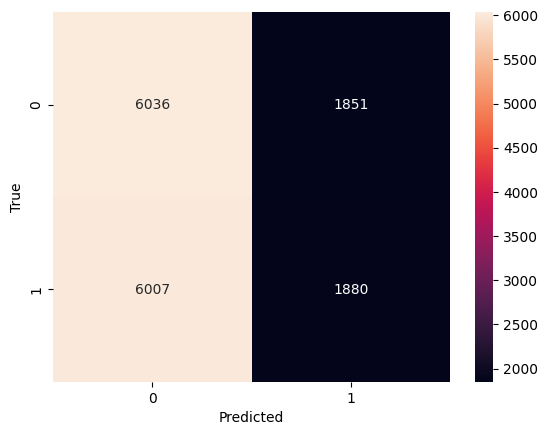

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(df['label_generated_real'], df['label_generated_pred'])
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

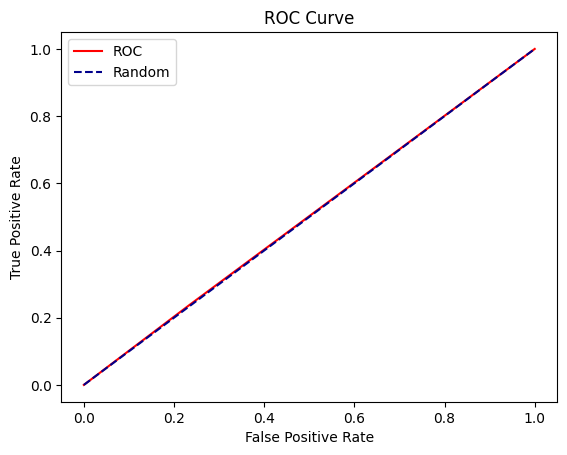

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
predict = df['label_generated_pred']
True_label = df['label_generated_real']
fpr, tpr, thresholds = roc_curve(True_label, predict)
auc = roc_auc_score(True_label, predict)
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(True_label, predict)
print(f"Accuracy: {accuracy}")

Accuracy: 0.501838468365665
